<a href="https://colab.research.google.com/github/Nick7900/AutoCUTS-LM-Analysis/blob/main/across_visits_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-state-visits testing
This tutorial demonstrates how to implement across-visits testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).

The across-state-visits test examines the relationship between signals from different modalities. In this example, data from 10 subjects who underwent Magnetoencephalography (MEG) scanning, primarily focusing on the Default Mode Network (DMN), are analyzed to explore spontaneous brain activity and its associations with pupil size fluctuations during rest.

To study the connection between pupil dilation and brain activity, we use a pre-trained Hidden Markov Model Time-Delayed Embedding (HMM-TDE) from [Vidaurre et al. 2018](https://www.nature.com/articles/s41467-018-05316-z) to decode brain states from MEG data. This generates the Viterbi path, which makes it possible to track brain states over time and their relationship with pupil size.

The test_across_visits function offers various statistical tests, including multivariate, univariate, one-vs-rest, and state pairs, as outlined in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time). This tutorial will guide you through the process, using the HMM-TDE model from Vidaurre et al. 2018."


## Table of Contents
* [Initial setup and data preparation](#setup)
    * [Load and prepare data](#load_data)
* [(OPTIONAL) Setup GLHMM ](#setup_glhmm)
    * [(OPTIONAL) Initialize and decode data from pretrained HMM-TDE model](#init_HMM)
* [Data handling](#data_handle)
* [HMM-aggregated probability distribution](#prop_dist)
* [Statistical Analysis](#stat_analysis)
    * [1.Multivariate test](#multi_test)
        * [Multiple Comparison (Multivariate test)](#multivariate_com)
        * [Visualisation (Multivariate test)](#multi_vis)
    * [2.Univariate test](#uni_test)
        * [Multiple Comparison (Univariate test)](#uni_com)
        * [Visualisation (Univariate test)](#uni_vis)
    * [3.One vs rest test](#one_test)
        * [Multiple Comparison (one vs rest test)](#one_com)
        * [Visualisation (one vs rest test)](#one_vis)
    * [4.State pairs test](#pair_test)
        * [Multiple Comparison (State pairs test)](#pair_com)
        * [Visualisation (State pairs test)](#pair_vis)
<a id="vis"></a>

## Initial setup and data preparation <a id="setup"></a>
Since we are using Google Colab for this workshop we first need to download the GLHMM toolbox

In [ ]:
!pip install -q git+https://github.com/vidaurre/glhmm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.1 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
import numpy as np
from glhmm import graphics, statistics, preproc, io, preproc, utils
import math

### Load and prepare data <a id="load_data"></a>

The data for this notebook is all in the folder ```occipal_processed```.
First, we look at the folder's contents.

In [ ]:
# Define path of files
PATH_RAW_DATA = Path(r'pupil_processed')
# List all files in the folder
files = [f for f in PATH_RAW_DATA.iterdir() if f.is_file()]
# Print the first 10 files
files

[WindowsPath('pupil_processed/gamma.npy'),
 WindowsPath('pupil_processed/hmm.mat'),
 WindowsPath('pupil_processed/idx_data_preproc.npy'),
 WindowsPath('pupil_processed/meg_data_preproc.npy'),
 WindowsPath('pupil_processed/pupil_data.npy'),
 WindowsPath('pupil_processed/vpath.npy'),
 WindowsPath('pupil_processed/vpath_surrogate_100.npy')]

Load the data for this statistical analysis.

We will explain what we are loading along the notebook

In [ ]:
# Load pupil data from a .npy file
pupil_data = np.load(PATH_RAW_DATA / "pupil_data.npy")
# Load preprocessed index data that marks every session
idx_data_preproc = np.load(PATH_RAW_DATA / "idx_data_preproc.npy")

**Loaded data**

```pupil_data``` are measurements of the pupil size that was obtained simultaneous along the MEG recordings

```idx_data_preproc```  marks the beginning and end timepoints of each session with a shape of ```[No. of sessions, 2]```.


Expore data



In [ ]:
print(f"Shape of 'pupil_data': {pupil_data.shape}")
print(f"Length of 'idx_data_preproc': {len(idx_data_preproc)}")
print(f"Shape of 'idx_data_preproc':\n{idx_data_preproc}")

Shape of 'pupil_data': (1473460,)
Length of 'idx_data_preproc': 19
Shape of 'idx_data_preproc':
[[      0   85996]
 [  85996  167903]
 [ 167903  243307]
 [ 243307  319513]
 [ 319513  395198]
 [ 395198  470960]
 [ 470960  545894]
 [ 545894  621406]
 [ 621406  697049]
 [ 697049  772958]
 [ 772958  849412]
 [ 849412  925357]
 [ 925357 1001103]
 [1001103 1077394]
 [1077394 1153600]
 [1153600 1229804]
 [1229804 1305766]
 [1305766 1391210]
 [1391210 1473460]]


The pupil data (```pupil_data```) consists of concatenated time series for all sessions, stored in a single array.

Additionally, ```idx_data_preproc``` MARKS the start and end timepoints of each session, with a total of 19 sessions in this dataset

Here you can see the plots of the pupillometry measurement for every sessions

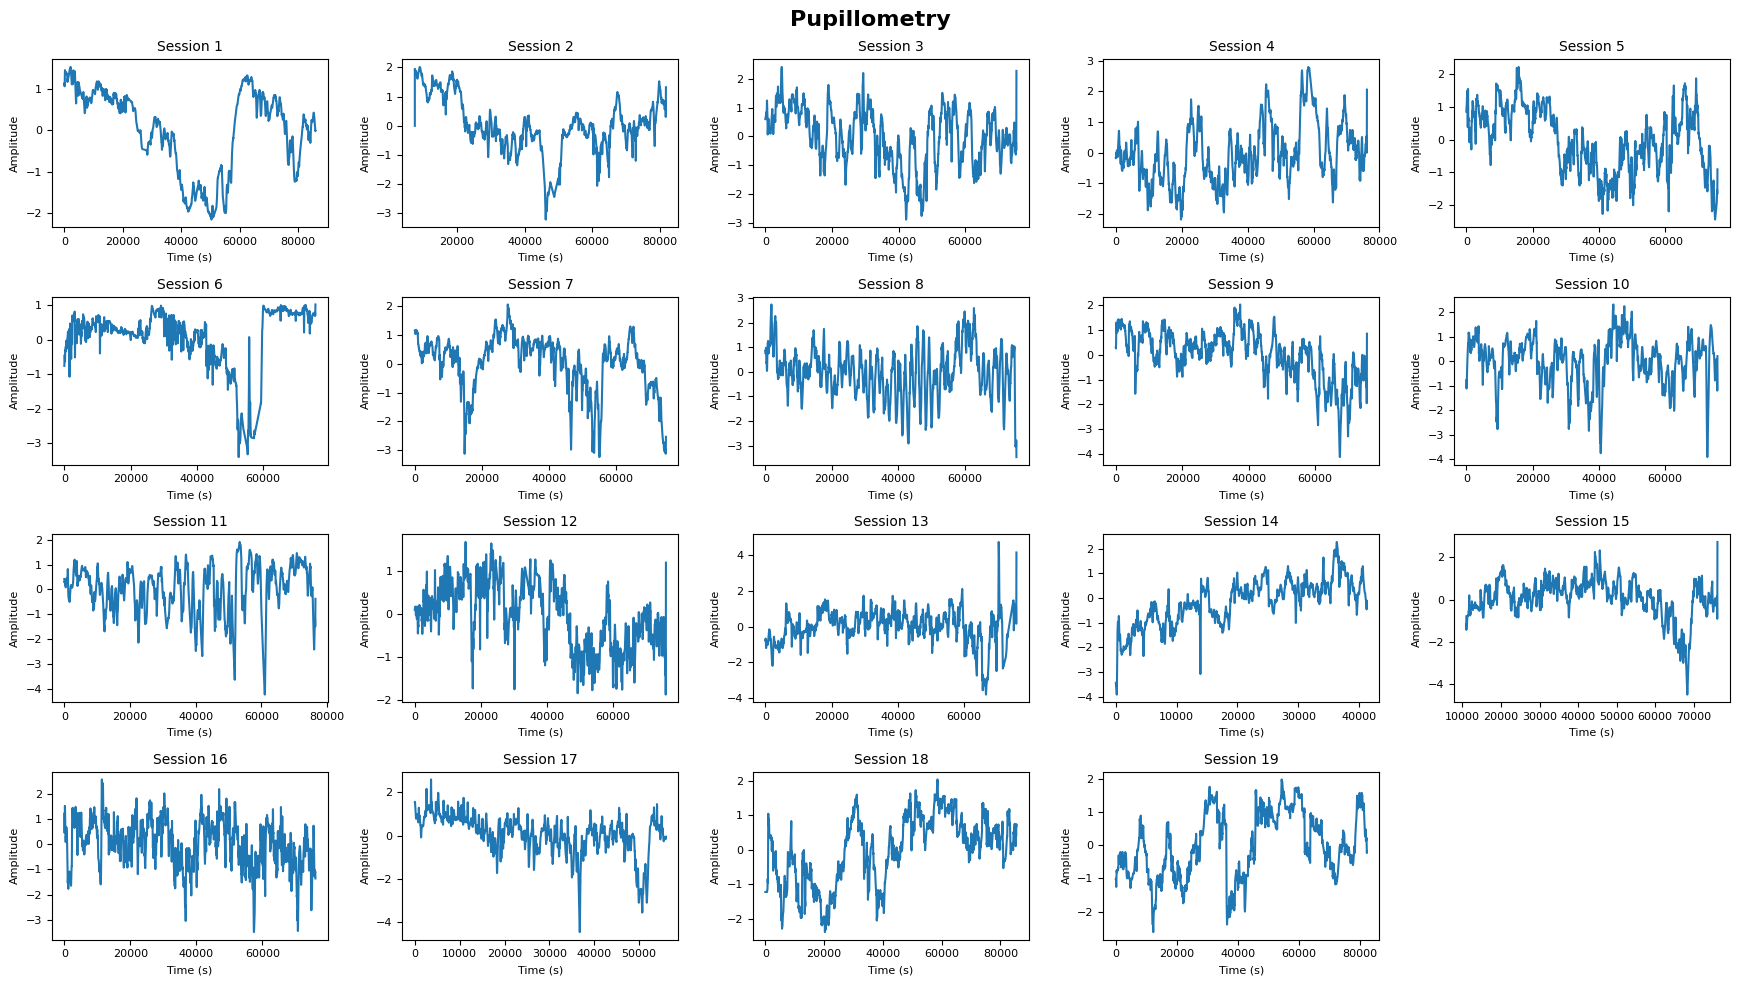

In [ ]:
# Calculate the number of rows and columns for the grid
n_plots = len(idx_data_preproc)
n_cols = math.ceil(math.sqrt(n_plots))
n_rows = math.ceil(n_plots / n_cols)

# Create the grid of subplots with a flexible figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 2.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each figure with enhanced details
for idx in np.arange(len(idx_data_preproc)):
    axes[idx].plot(pupil_data[idx_data_preproc[idx,0]:idx_data_preproc[idx,1]], linestyle='-', linewidth=1.5)  # Adjust line properties
    axes[idx].set_title(f'Session {idx+1}', fontsize=10)  # Set a more descriptive title
    axes[idx].set_xlabel('Time (s)', fontsize=8)  # Label x-axis
    axes[idx].set_ylabel('Amplitude', fontsize=8)  # Label y-axis
    axes[idx].tick_params(axis='both', which='major', labelsize=8)  # Adjust tick label size

# Remove any empty subplots
for ax in axes[len(idx_data_preproc):]:
    fig.delaxes(ax)

# Add a main title for the entire figure
fig.suptitle('Pupillometry', fontsize=16, weight='bold')

# Automatically adjust spacing to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()


## (OPTIONAL) Setup GLHMM <a id="setup_glhmm"></a>
In this workshop, we will use the pretrained values of ```Gamma``` and ```vpath``` that will be in the downbelow cell. This eliminates the need for preparing an HMM model.

* ```meg_data_preproc``` are Magnetoencephalography (MEG) data that has been preprocessed beforehand. Specifically, we applied Independent Component Analysis (ICA) to remove noise components, removed bad channels and standardized the MEG data to keep a consistent scaling across measurements.

* ```gamma``` were decoded using a HMM-TDE

* ```vpath``` was also decoded from the HMM-TDE, and is the Viterbi path of the signal


The training and decoding steps have been removed as they are no longer necessary for this session. In the original version, these steps could take 6-10 minutes, which we now avoid by working with the preloaded data


In [ ]:
# Load preprocessed MEG (magnetoencephalography) data from a .npy file
meg_data_preproc = np.load(PATH_RAW_DATA / "meg_data_preproc.npy")
# Load gamma data decoded from the HMM-TDE
Gamma = np.load(PATH_RAW_DATA / "gamma.npy")
# Load viterbi path decoded from the HMM-TDE
vpath = np.load(PATH_RAW_DATA / "vpath.npy")

### (OPTIONAL) Initialize and decode data from pretrained HMM-TDE model <a id="init_HMM"></a>
However, if you are interested in feeding your data into an HMM model, then for this tutorial we used TDE-HMM model used in the [Vidaurre et al. 2018](https://www.nature.com/articles/s41467-018-05316-z).

For reference, in the original study, the TDE-HMM model used a PCA projection of 84 components and 7 time lags, creating a temporal embedding window that captures dynamic patterns in the data.

The pre-trained model can be prepared with the following code using the ```read_flattened_hmm_mat``` function. :
```python
# Load the pretrained model as a glhmm object
hmm = io.read_flattened_hmm_mat(PATH_RAW_DATA / 'hmm.mat')
hmm.trained = True  # Set to True since the model is already trained

# Load the regular HMM and retrieve the PCA settings
hmmmat = scipy.io.loadmat(PATH_RAW_DATA / 'hmm.mat')
pca_proj = hmmmat["train"]["A"][0][0]
n_states = hmmmat["K"][0][0]

# Specify the number of embedded lags
embedded_lags = 7
lags = np.arange(-embedded_lags, embedded_lags + 1)

```


### (OPTIONAL) Decode pretrained Hidden Markov Model-TDE model <a id="train_HMM"></a>
Now that the pretrained HMM-TDE is ready, we can decode the preprocessed MEG data for each session to obtain the Gamma values and the Viterbi path.

Before decoding, we need to prepare the data in HMM-TDE format using the ```build_data_tde``` function. Since we are not modeling interactions between two sets of time series, we will set X=None. The preprocessed time series data (meg_data_tde) will be passed to Y, along with the session start and end indices (indices_tde).


```python
# Initialize lists to store gamma values and Viterbi paths
gamma_list = []
viterbi_path_list = []

# Process each session separately
for idx_session in tqdm(range(len(idx_data_preproc))):
    # Extract MEG data for the current session
    mes_sess = meg_data_preproc[idx_data_preproc[idx_session][0]:idx_data_preproc[idx_session][1], :]
    indices_sess = np.expand_dims(np.array([0, mes_sess.shape[0]]), axis=0)

    # Build the MEG data in TDE format for the current session
    meg_data_tde, indices_tde = preproc.build_data_tde(
        mes_sess,
        indices_sess,
        lags=lags,
        pca=pca_proj,
        standardise_pc=True
    )
    
    # Decode to get Gamma values
    gamma, _, _ = hmm.decode(X=None, Y=meg_data_tde, indices=indices_tde)
    gamma_list.append(gamma)
    
    # Decode to get the Viterbi path
    viterbi_path = hmm.decode(X=None, Y=meg_data_tde, indices=indices_tde, viterbi=True)
    viterbi_path_list.append(viterbi_path)

## Data handling <a id="data_handle"></a>
Let's take a moment to review the data we'll be analyzing. Our goal is to identify associations between the HMM state time courses from the Viterbi path and the simultaneously measured pupillometry data.

The predictor matrix (D) consists of the pupillometry measurements, while the target matrix (R) contains the Viterbi paths we just decoded for each session. Now, let's examine the dimensions of the pupillometry data and the decoded Viterbi path for the first session.



In [ ]:
# Display dimensions of the data
print(f"Dimension of every sessions in D-matrix 'pupil_data': {pupil_data.shape}")
print(f"Dimension of every sessions in R-matrix 'vpath': {vpath.shape}")

Dimension of every sessions in D-matrix 'pupil_data': (1473460,)
Dimension of every sessions in R-matrix 'vpath': (1473194, 12)


We notice a difference in the lengths of the first session in ```pupil_data``` (1473460,) and ```vpath``` (1473194, 12).  This change happens when using the HMM-TDE, which applies a lag time of 7 in this case. This means it removes the first and last 7 values from the original time series.

Given that we have 19 sessions and the lag accounts for a total of 14 values (from -7 to +7), we can see why the length of vpath matches. Specifically, if we calculate
that 1473460-(19*14) is the 1473194 just like the shape of ```vapth```.


To align the length of vpath with the original ```pupil_data```, we need to add 7 values at both the beginning and the end of the Viterbi path. We can achieve this using the ```pad_vpath``` function.

Before we do that, we need to update the indices that mark the start and end of each session in the vpath data. We can obtain these updated indices with the following code:

In [ ]:
# Specify the number of embedded lags
embedded_lags = 7
# Get the indices for the HMM-TDE data
idx_data_tde =statistics.get_indices_from_list(np.diff(idx_data_preproc)-embedded_lags*2, count_timestamps=False)
print(f"Shape of 'idx_data_tde':\n{idx_data_tde}")

Shape of 'idx_data_tde':
[[      0   85982]
 [  85982  167875]
 [ 167875  243265]
 [ 243265  319457]
 [ 319457  395128]
 [ 395128  470876]
 [ 470876  545796]
 [ 545796  621294]
 [ 621294  696923]
 [ 696923  772818]
 [ 772818  849258]
 [ 849258  925189]
 [ 925189 1000921]
 [1000921 1077198]
 [1077198 1153390]
 [1153390 1229580]
 [1229580 1305528]
 [1305528 1390958]
 [1390958 1473194]]


Now we can pad the vpath data

In [ ]:
# Pad vpath
viterbi_path_list_pad = [statistics.pad_vpath(vpath[indices[0]:indices[1]],embedded_lags) for indices in idx_data_tde]
# Concatenate the data to numpy arrays
vpath_data_con =np.concatenate(viterbi_path_list_pad,axis=0)
# Display dimensions of the dataset we are going to use for the statistical testing
print(f"Dimension of the D-matrix 'pupil_data': {pupil_data.shape}")
print(f"Dimension of the R-matrix 'vpath_data_con': {vpath_data_con.shape}")

Dimension of the D-matrix 'pupil_data': (1473460,)
Dimension of the R-matrix 'vpath_data_con': (1473460, 12)


All dimensions now match and are ready for the statistical test. However, we can optimize the ```vpath_data_con``` array, which currently has the shape ```[(number of timepoints * number of subjects/sessions), number of states]```, by converting it into a single array with the shape ```[(number of timepoints * number of subjects/sessions)]```.

Since each column in ```vpath_data_con``` represents a state with only one active state (value 1) per row (one-hot encoded), converting the array from a float type to an integer type will significantly reduce memory usage without losing any information.

Below are the first 10 timepoints of vpath_data_con, showing that state 10 is active for all of them:

In [ ]:
print(vpath_data_con[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


Next, we convert vpath_data_con to a 1D array:

In [ ]:
vpath_data = vpath_data_con.nonzero()[1] + 1
print(f"Shape of 'vpath_data'{vpath_data.shape}")
print(vpath_data[:10])


Shape of 'vpath_data'(1473460,)
[10 10 10 10 10 10 10 10 10 10]


As shown, the result confirms that state 10 is active for all timepoints. This conversion allows us to work with a much smaller datatype, which is more efficient for the upcoming permutation testing on the ```vpath_data``` array.

#### HMM-aggregated probability distribution <a id="prop_dist"></a>
We can also visualize the proportion of time spent in each state for each session by calculating the Fractional Occupancy.\
This helps us assess how consistently the model captures the MEG data across different sessions.
We calculate FO using the ```get_FO``` function from the ```utils``` module, which provides the probability distribution for each state across the time series. To plot the FO, we use the ```plot_FO``` function from the ```graphics``` module.

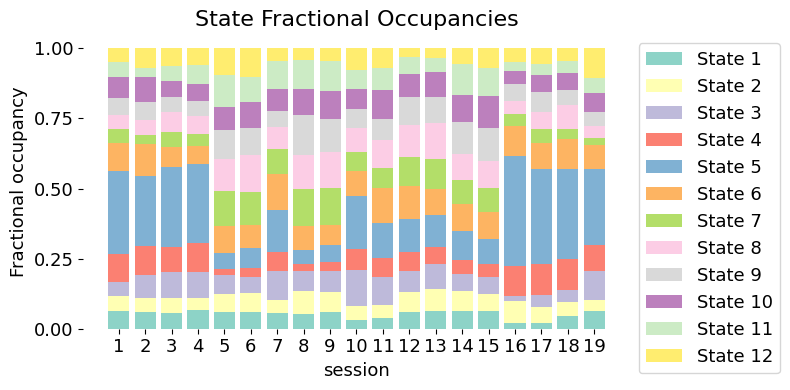

In [ ]:
# Calculate the fractional occupancy
FO = utils.get_FO(Gamma, idx_data_tde)
graphics.plot_FO(FO, num_ticks=len(idx_data_tde), xlabel="session")

We observe that the HMM effectively captures the different states across sessions, as the proportions appear quite similar.\
However, it's important to note that there are session-to-session variabilities in each scanning session.

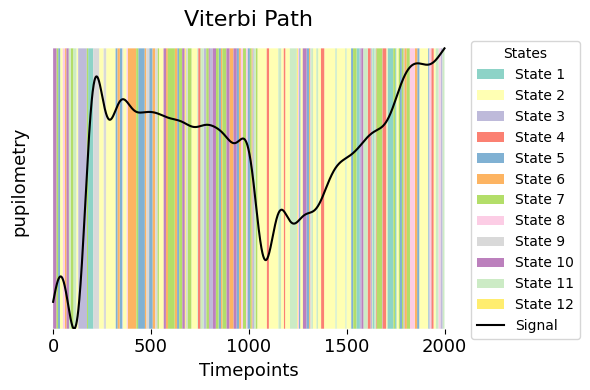

In [ ]:
xlim = 2000
data_test =pupil_data[0:idx_data_preproc[0,1]]
nan_exclude =~np.isnan(data_test)
# Normalize the sig_data to the range [0, 1]
min_value = np.min(data_test[nan_exclude][:xlim])
max_value = np.max(data_test[nan_exclude][:xlim])
normalized_sig_data = ((data_test[nan_exclude][:xlim] - min_value) / (max_value - min_value))
graphics.plot_vpath(vpath_data_con[:xlim],normalized_sig_data, yticks=False, figsize=(6,4), ylabel="pupilometry")

## Statistical Analysis <a id="stat_analysis"></a>
As we move to the next phase of this tutorial, let's dive into how we can use the ```test_across_visits``` function.

This function is designed to identify relationships between the continous measured pupillometry (D) and HMM state time courses (R) through permutation testing. This test is particularly useful for examining whether some specific HMM states are significantly changing in relation to the signal that are measured, which is the pupillometry in this case.

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis — that there is no difference or relationship between variables of interest to be tested


**Setup testing parameters**\
Creating the Viterbi path surrogates can take hours with this dataset.
Therefore, we will load a precomputed variable containing the 100 surrogates/permutations. This variable is a numpy array, with its length corresponding to the number of sessions.

In [ ]:
vpath_surrogates =np.load(PATH_RAW_DATA/'vpath_surrogate_100.npy')
print(f"Shape of vpath_surrogates: {vpath_surrogates.shape}")

Shape of vpath_surrogates: (1473460, 100)


What we can observe here is that the concatenated Viterbi path array has a shape of (1473460, 100) ```[no. of timepoints, no. of permutations]```. The same number of timepoints and 100 different permutations have been performed.

### 1.Multivariate test <a id="multi_test"></a>
In this analysis, we are testing how well changes in pupil dilation (D-data) predict brain states (R-data) identified through the HMM-TDE. Using ($R^2$) as a measure, we want to see if pupil size consistently explains the variability in these brain states over time.

If we find a significant result for a particular state, it means that pupil dilation explains more of the variance in that state, indicating a strong predictive relationship. This implies that pupil size is not just associated with the brain state but also plays a role in predicting its occurrence and can therefore give meaningful connection between physiological changes and brain state transitions.



**Explore data**\
First, let us look at the data that we are interested in:

In [ ]:
print(f"Data dimension of simulated signal: {pupil_data.shape}")
print(f"Data dimension of viterbi path: {vpath_data.shape}")

Data dimension of simulated signal: (1473460,)
Data dimension of viterbi path: (1473460,)


In this example, the pupiliometry, represented as a 1473460x1 array, is a continuous variable of all the measurements from the different sessions.\
The corresponding  Viterbi path is a 1473460x1 array, representing discrete states for each time point based on a simulated path. But it could also have been a matrix of shape 1473460 x no. of states, where each state is one-hot encoded as a binary vector.


**Run the ```test_across_visits``` function**:\
To run the ```test_across_visits``` function requires providing inputs of pupillometry (D) and HMM state time courses (R). For regression-based permutation testing, set ```method="multivariate"``` and set ```test_statistics_option=True``` if you want export of the permutation distribution.
Additionally, input the number of states (12 in this case) and specify the pre-prepared permutation matrix of the Viterbi path with ```vpath_surrogates=vpath_permutation_matrix```



In [ ]:
# Set the parameters for across sessions within subject testing
method = "multivariate"  # Method for testing; "multivariate" is chosen for this analysis
Nperm = 100  # Number of permutations for the statistical test (default is 0 if not specified)
test_statistic = True  # Option to export the permutation distribution of the test statistic
n_states = 12
# Perform the across-visits testing for using the specified parameters
results_visits_mul_com = statistics.test_across_visits(
    pupil_data,  # Input data for pupillometry
    vpath_data,  # Input data for HMM state time courses
    method=method,  # The method to use for testing
    Nperm=Nperm,  # Number of permutations for the test
    test_statistics_option=test_statistic,  # Option to export test statistics
    vpath_surrogates=vpath_surrogates  # Precomputed permutation matrix for the Viterbi path
)

100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


We can now examine the local ```results_visits_mul_com``` variable.

In [ ]:
results_visits_mul_com

{'pval': array([0.00990099, 0.00990099, 0.07920792, 0.00990099, 0.99009901,
        0.06930693, 0.07920792, 0.13861386, 0.06930693, 0.01980198,
        0.02970297, 0.00990099]),
 'base_statistics': array([-0.05504799, -0.06264885, -0.08131074, -0.07815331, -0.23674391,
        -0.10271542, -0.08085094, -0.09571649, -0.08499485, -0.08604265,
        -0.07639242, -0.06490076]),
 'test_statistics': array([[-0.05504799, -0.06264885, -0.08131074, ..., -0.08604265,
         -0.07639242, -0.06490076],
        [-0.05951526, -0.07002409, -0.08464612, ..., -0.08915693,
         -0.07884711, -0.06895236],
        [-0.05871314, -0.06608172, -0.08643346, ..., -0.08955806,
         -0.07840395, -0.07085256],
        ...,
        [-0.05861163, -0.06652201, -0.08438147, ..., -0.0918374 ,
         -0.08119959, -0.06852171],
        [-0.05713002, -0.06929362, -0.08050103, ..., -0.09031791,
         -0.07737939, -0.06722401],
        [-0.05750845, -0.06814952, -0.08217822, ..., -0.08730691,
         -0.0

What we can see here is that ```results_visits_reg_com``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```.

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_visits```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.


#### Multiple Comparison (Multivariate test) <a id="multivariate_com"></a>
Here we will apply p-value correction using Benjamini/Hochberg on the multivariate test (```result_regression```) to take into account the risk of type 1 errors (false positive) when doing to multiple testing.



In [ ]:
pval_mul_corrected, rejected_reg_corrected =statistics.pval_correction(results_visits_mul_com["pval"], method='fdr_bh')

#### Visualisation (Multivariate test) <a id="vis_reg"></a>
Now that we have performed our test, we can then visualize the corrected and uncorrected p-values.\
We will make different plots using the ```graphics.py``` module


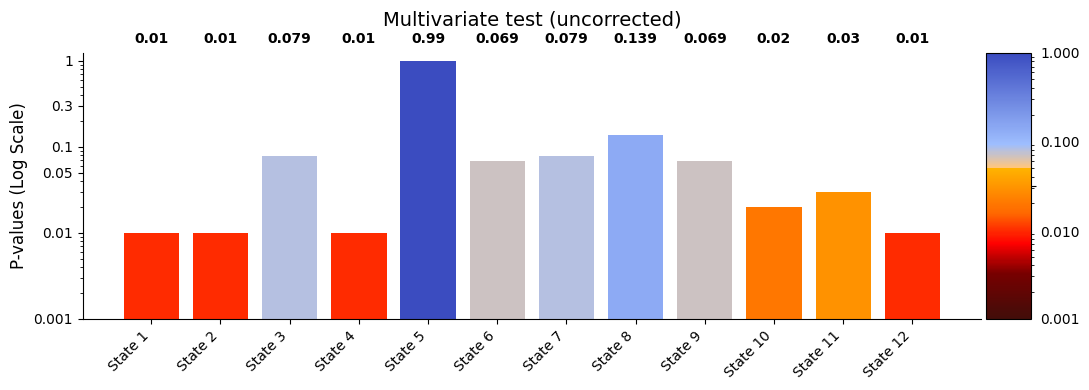

In [ ]:
xticklabels = [f"State {i+1}"for i in range(len(results_visits_mul_com["pval"])) ]
graphics.plot_p_values_bar(results_visits_mul_com["pval"], title_text ="Multivariate test (uncorrected)",
                      figsize=(11, 4), xlabel_rotation=45, xticklabels=xticklabels, pval_text_hight_same=True)

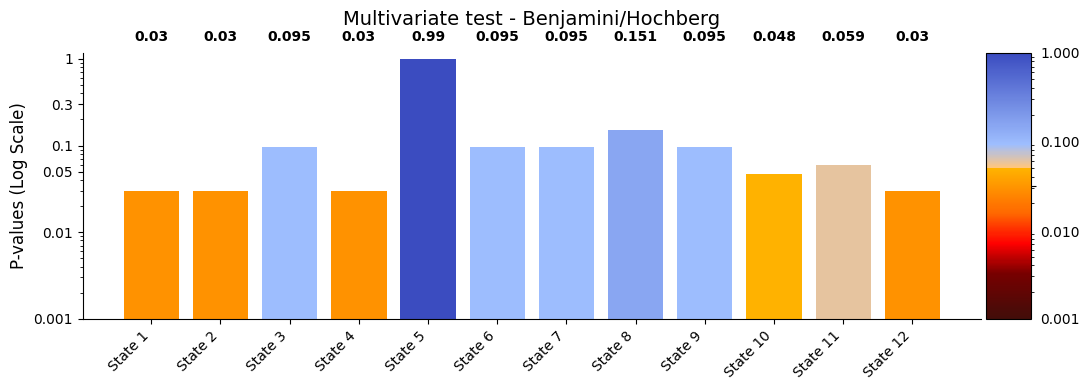

In [ ]:
# plot Benjamini/Hochberg correction
graphics.plot_p_values_bar(pval_mul_corrected, title_text ="Multivariate test - Benjamini/Hochberg",
                      figsize=(11, 4),xlabel_rotation=45, xticklabels=xticklabels,pval_text_hight_same=True)

### 2.Univariate test <a id="uni_test"></a>
In this analysis, the correlation we are testing refers to the strength and direction of the relationship between pupil dilation (D-data) and the brain states (R-data) identified through the HMM-TDE. Specifically, we want to know whether changes in pupil size are consistently associated with certain brain states over time.

If we find a significant correlation for a particular state, it means that when that state appears, pupil size tends to follow a consistent pattern—either increasing or decreasing. This suggests that something about the pupil dilation is affected when the brain enters that state.

**Run the ```test_across_visits``` function**:\
To run the ```test_across_visits``` function requires providing inputs of pupillometry (D-data) and HMM state time courses (R-data). All the settings are the same as before, beside of setting ```method="univariate"```.


In [ ]:
# Set the parameters for across sessions within subject testing
method = "univariate"

# Perform the multivariate test
results_visits_uni_com = statistics.test_across_visits(
    pupil_data,
    vpath_data,
    method=method,
    Nperm=Nperm,
    test_statistics_option=True,
    n_states=n_states,
    vpath_surrogates=vpath_surrogates)


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


#### Multiple Comparison (Univariate test)<a id="uni_vis"></a>
Applying p-value correction using Benjamini/Hochberg to take into account the risk of type 1 errors (false positive) when doing to multiple testing.


In [ ]:
pval_uni_corrected, _ =statistics.pval_correction(results_visits_uni_com["pval"], method='fdr_bh')

#### Visualisation (Univariate test) <a id="vis_uni"></a>


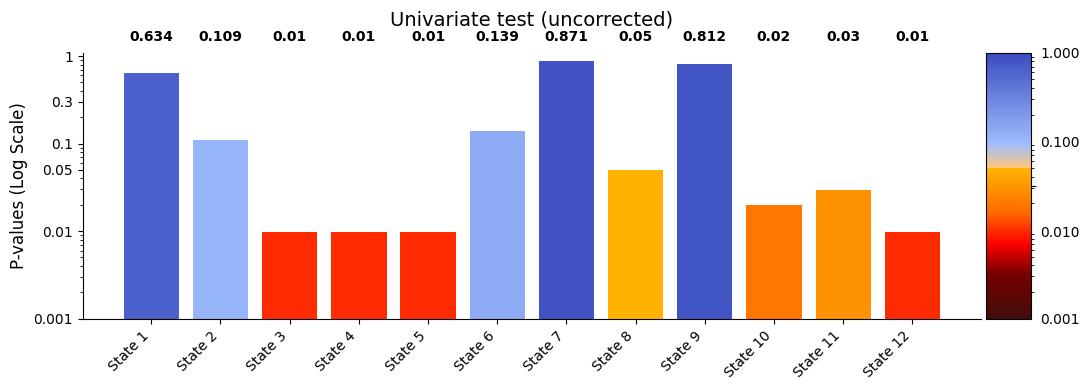

In [ ]:
# Plot p-values
graphics.plot_p_values_bar(results_visits_uni_com["pval"], title_text ="Univariate test (uncorrected)",
                      figsize=(11, 4), xlabel_rotation=45, xticklabels=xticklabels, pval_text_hight_same=True)
                      # plot Benjamini/Hochberg correction

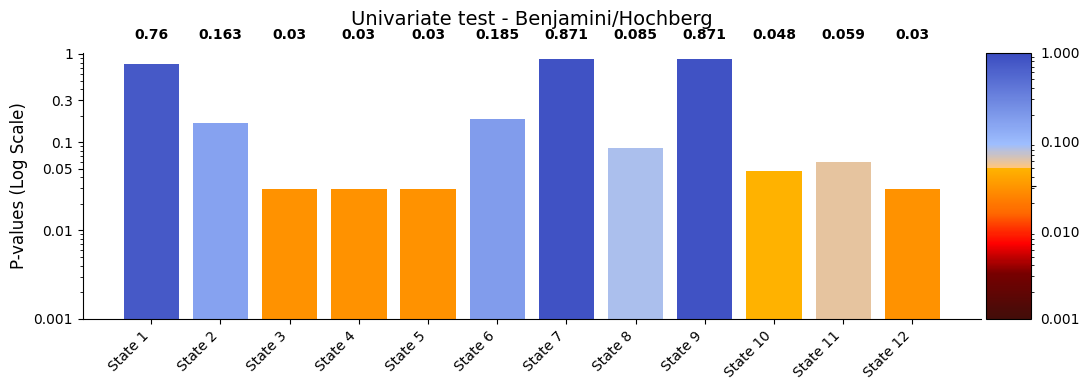

In [ ]:
graphics.plot_p_values_bar(pval_uni_corrected, title_text ="Univariate test - Benjamini/Hochberg",
                      figsize=(11, 4),xlabel_rotation=45, xticklabels=xticklabels,pval_text_hight_same=True)

### 3.One vs rest test <a id="one_test"></a>

In this analysis, we use permutation testing to compare the signal during a specific brain state, such as state 1, with the combined influence of all other states. This "one vs rest" approach helps determine whether a particular state has a distinct effect on the signal, such as pupil dilation (D-data). By focusing on the mean signal difference, we can assess whether that state uniquely influences the signal compared to the others. In this way, the test can reveal which states have a significant impact on pupil size, potentially identifying those that are linked to the Default Mode Network.

**Run the ```test_across_visits``` function**:\
To run the ```test_across_visits``` function requires providing inputs of pupillometry (D) and HMM state time courses (R). All the settings are the same as before, beside of setting ```method="one_vs_rest"```.

In [ ]:
# Set the parameters for across sessions within subject testing
method = "one_vs_rest"

results_visits_ons_rest_com = statistics.test_across_visits(
    pupil_data,
    vpath_data,
    method=method,
    Nperm=Nperm,
    test_statistics_option=True,
    n_states=n_states,
    vpath_surrogates=vpath_surrogates)


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


#### Multiple Comparison (one vs rest test) <a id="one_com"></a>
Applying p-value correction using Benjamini/Hochberg to take into account the risk of type 1 errors (false positive) when doing to multiple testing.



In [ ]:
pval_one_rest_corrected, _ =statistics.pval_correction(results_visits_ons_rest_com["pval"], method='fdr_bh')

#### Visualisation (one vs rest test) <a id="one_vis"></a>

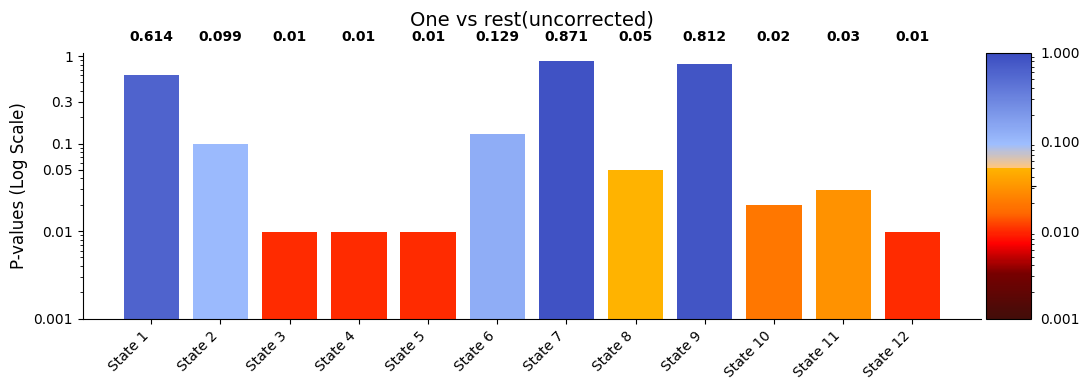

In [ ]:
# Plot p-values
graphics.plot_p_values_bar(results_visits_ons_rest_com["pval"], title_text ="One vs rest(uncorrected)",
                      figsize=(11, 4), xlabel_rotation=45, xticklabels=xticklabels, pval_text_hight_same=True)

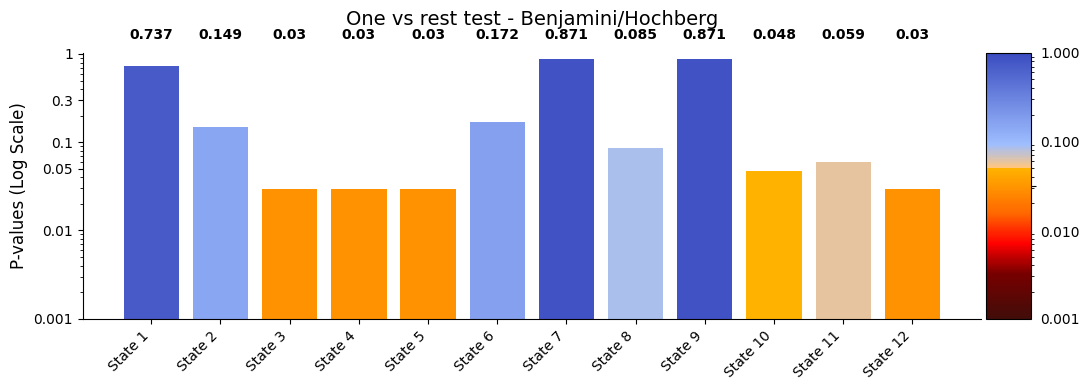

In [ ]:
# plot Benjamini/Hochberg correction
graphics.plot_p_values_bar(pval_one_rest_corrected, title_text ="One vs rest test - Benjamini/Hochberg",
                      figsize=(11, 4),xlabel_rotation=45, xticklabels=xticklabels,pval_text_hight_same=True)

### 4.State pairs test <a id="pair_test"></a>

In this analysis, we use permutation testing to compare the average pupil size (D-data) between different pairs of brain states, such as state 1 versus state 2 or state 1 versus state 3. This method helps us determine if the differences in pupil size between specific state pairs are statistically significant. By examining these differences, we can see if certain states are linked to unique changes in pupil dilation and can therefore shed light on how various brain states may influence pupil size differently.

It allows us to identify distinct effects that might not be visible when looking at each state individually. Additionally, it clarifies how transitions between states impact pupil size, showing whether moving from one state to another causes significant changes. Ultimately, this analysis can help us to identify which brain states are particularly relevant for the DMN.


**Run the ```test_across_visits``` function**:\
To run the ```test_across_visits``` function requires providing inputs of pupillometry (D) and HMM state time courses (R). All the settings are the same as before, beside of setting ```method="state_pairs"```.

In [ ]:
# Set the parameters for across sessions within subject testing
method = "state_pairs"

results_visits_state_pairs_com = statistics.test_across_visits(
    pupil_data,
    vpath_data,
    method=method,
    Nperm=Nperm,
    test_statistics_option=True,
    n_states=n_states,
    vpath_surrogates=vpath_surrogates)


Pairwise comparisons: 100%|██████████| 66/66 [03:23<00:00,  3.09s/it]


#### Multiple Comparison (State pairs test) <a id="pair_com"></a>
Applying p-value correction using Benjamini/Hochberg to take into account the risk of type 1 errors (false positive) when doing to multiple testing.



In [ ]:
pval_state_pairs_corrected, _ =statistics.pval_correction(results_visits_state_pairs_com["pval"], method='fdr_bh')

#### Visualisation (State pairs test) <a id="pair_vis"></a>


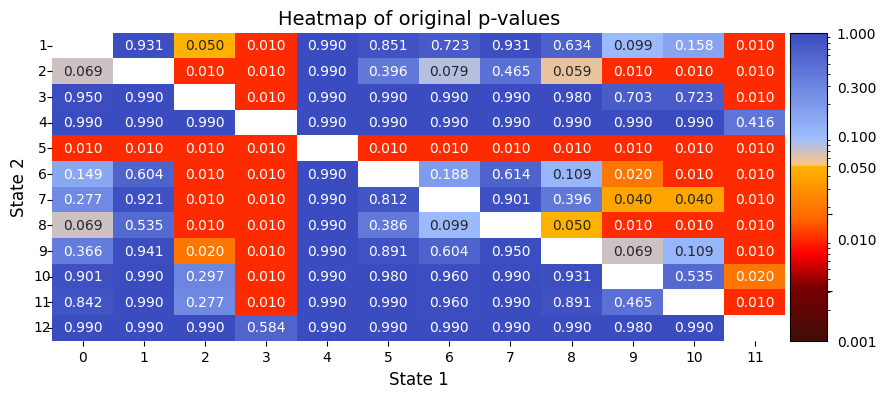

In [ ]:
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(results_visits_state_pairs_com["pval"],
                             title_text ="Heatmap of original p-values",figsize=(10, 4), xlabel="State 1", ylabel="State 2", alpha=0.05, none_diagonal=True, annot=True)

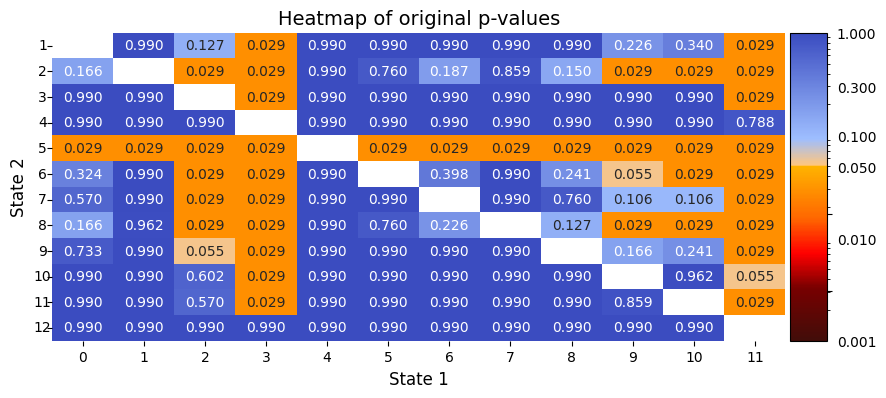

In [ ]:
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(pval_state_pairs_corrected,
                             title_text ="Heatmap of original p-values",figsize=(10, 4), xlabel="State 1", ylabel="State 2", alpha=0.05, none_diagonal=True, annot=True)